# Lista 1b - Visão Computacional

## Parte A
* As imagens foram convertidas de coloridas fornecidas para nı́veis de cinza.

* Foi encontrado um valor de $τ$ manualmente, de forma que foi segmentado o maior número possı́vel de moedas e cartões nas imagens em nı́vel de cinza.

O código abaixo é usado para selecionar a imagem que se deseja trabalhar.

In [1]:
from ipywidgets import widgets
from IPython.display import display
img_select = widgets.RadioButtons(
    options=["moedas.jpg", "cores.jpeg"],
    description='Imagem:',
    disabled=False
)
display(img_select)

RadioButtons(description=u'Imagem:', options=('moedas.jpg', 'cores.jpeg'), value='moedas.jpg')

O código a seguir carrega a imagem na memória e a converte para níveis de cinza.

In [2]:
from matplotlib import pyplot as plt
import cv2
import sys
import numpy as np
import OtsuPyre.otsu as otsu
import peakutils
%matplotlib inline

def plot_gray(image):
    """Plota a imagem em niveis de cinza"""
    plt.imshow(image, cmap='gray')
    plt.show()

# Abre a imagem escolhida
image = cv2.imread(img_select.value)

# Converte a imagem para nivel de cinza
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

Então, pode-se limiarizar e segmentar a imagem manualmente com o slider.

* Um limiar de $τ=116$ aparenta ser um valor razoável para a imagem das moedas.

* Com um limiar $τ=140$ foi possível segmentar 5 dos 6 cartões, faltando apenas o cartão amarelo.


In [87]:
# Limiariza a imagem a partir de um limiar manual
def threshold_manual(thres):
    retval, th_image = cv2.threshold(gray_image, thres, 255, cv2.THRESH_BINARY_INV)
    plot_gray(th_image)
widgets.interact(threshold_manual , thres=(0, 255, 1))

interactive(children=(IntSlider(value=127, description=u'thres', max=255), Output()), _dom_classes=('widget-interact',))

<function __main__.threshold_manual>

O algoritmo de limiarização e segmentação foi modificado, de forma a utilizar dois limiares, $τ_1$ e $τ_2$, para definir uma faixa de valores de interesse (ou de não interesse) para a binarização.

* Limiares $τ_1=110$ e $τ_2=205$ aparentam isolar as moedas do fundo.
* Enquanto que $τ_1=140$ e $τ_2=210$ segmentam os cartões coloridos.

In [14]:
# Limiariza a imagem com dois níveis
def threshold_interval_interactive(min_thres, max_thres):
    th_image = cv2.inRange(gray_image, min_thres, max_thres)
    th_image = cv2.bitwise_not(th_image)
    plot_gray(th_image)
widgets.interact_manual(threshold_interval_interactive , min_thres=(0, 255, 1), max_thres=(0, 255, 1))

interactive(children=(IntSlider(value=127, description=u'min_thres', max=255), IntSlider(value=127, description=u'max_thres', max=255), Button(description=u'Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widget-interact',))

<function __main__.threshold_interval_interactive>

Operações morfológicas de erosão, dilatação, abertura e fechamento foram aplicadas nas imagens. Um kernel apropriado foi selecionado, de acordo com o formato e tamanho dos objetos de cada imagem. Para as moedas, um kernel elíptico de (3,3) foi selecionado. Enquanto que para os cartões, um kernel uniforme de (7,7) obteve resultados melhores.

Para as moedas, repetiu-se cinco vezes as operações:

* Abertura (para limpar o ruído)
* Duas dilatações (para preencher as moedas)
* Fechamento (para fechar os pequenos furos nas moedas)

Para os cartões, realizou-se os passos:

* Abertura 20 vezes para limpar o ruído
* Erosão para separar os cartões do fundo

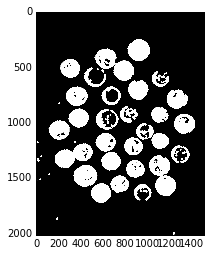

In [89]:
# Limiariza a imagem com dois niveis e transformacoes morfologicas

if img_select.value == 'moedas.jpg':
    min_thres = 110
    max_thres = 205
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
    th_image = cv2.inRange(gray_image, min_thres, max_thres)
    th_image = cv2.bitwise_not(th_image)
    for i in xrange(5):
       th_image = cv2.morphologyEx(th_image, cv2.MORPH_OPEN, kernel)
       th_image = cv2.dilate(th_image,kernel,iterations=2)
       th_image = cv2.morphologyEx(th_image, cv2.MORPH_CLOSE, kernel)
    plot_gray(th_image)
else:
    min_thres = 140
    max_thres = 210
    th_image = cv2.inRange(gray_image, min_thres, max_thres)
    th_image = cv2.bitwise_not(th_image)
    kernel = np.ones((7,7),np.uint8)
    for i in xrange(20):
        th_image = cv2.morphologyEx(th_image, cv2.MORPH_OPEN, kernel)
    th_image = cv2.erode(th_image, kernel, iterations=1)
    
    plot_gray(th_image)

## Parte B
1. Pesquise o método de Otsu e explique de forma resumida o método.
2. Converta as imagens colorida fornecidas para uma imagem em nı́veis de cinza.
3. Aplique o método de Otsu para binarização das imagens em nı́vel de cinza.

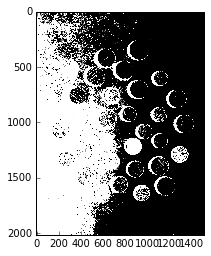

Threshold Otsu: 151.0


In [90]:
# Binarizacao aplicando o metodo de Otsu
retval, th_image = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
plot_gray(th_image)
print "Threshold Otsu:", retval

In [125]:
def estimate_thresholds(hist_img, thres, min_dist, num_levels):
    indexes = peakutils.indexes(hist_img, thres=thres, min_dist=min_dist)
    plt.plot(range(num_levels), hist_img)
    y_ind = np.zeros(num_levels)
    for i in indexes:
        y_ind[i] = hist_img[i]
    plt.plot(range(num_levels), y_ind)
    x_th = []
    for i in xrange(len(indexes)-1):
        x_th.append((indexes[i]+indexes[i+1])/2)
    y_th = np.zeros(num_levels)
    for i in x_th:
        y_th[i] = hist_img[i]
    plt.plot(range(num_levels), y_th)
    plt.show()
    return x_th, indexes
def multi_otsu(sensitivity, min_peak_dist):
    ot = otsu.OtsuFastMultithreshold()
    ot.load_image(gray_image)
    hist_img = cv2.calcHist([gray_image],[0],None,[256],[0,256])
    hist_img = hist_img.ravel()
    kThresholds, indexes = estimate_thresholds(hist_img, sensitivity, min_peak_dist, 256)
    print 'Thresholds:', kThresholds
    multi_otsu_img = ot.apply_thresholds_to_image(kThresholds)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
    multi_otsu_img = cv2.morphologyEx(multi_otsu_img, cv2.MORPH_OPEN, kernel)
    multi_otsu_img = cv2.dilate(multi_otsu_img,kernel,iterations=3)
    plot_gray(multi_otsu_img)

sensitivity_value = 0.0
min_peak_dist_value = 0
if img_select.value == 'cores.jpeg':
    sensitivity_value = 0.15
    min_peak_dist_value = 5 
else:
    sensitivity_value = 0.08
    min_peak_dist_value = 13
widgets.interactive(multi_otsu,
    sensitivity=widgets.FloatSlider(min=0.01, max=1.0, step=0.01, value=sensitivity_value),
    min_peak_dist=widgets.IntSlider(min=1,max=128,step=1,value=min_peak_dist_value))

interactive(children=(FloatSlider(value=0.15, description=u'sensitivity', max=1.0, min=0.01, step=0.01), IntSlider(value=5, description=u'min_peak_dist', max=128, min=1), Output()), _dom_classes=('widget-interact',))

In [13]:
img_blur = cv2.GaussianBlur(gray_image,(5,5),0)
# find normalized_histogram, and its cumulative distribution function
hist = cv2.calcHist([img_blur],[0],None,[256],[0,256])
hist_norm = hist.ravel()/hist.max()
Q = hist_norm.cumsum()
bins = np.arange(256)
fn_min = np.inf
thresh_i = -1
thresh_j = -1
for i in xrange(1,255):
    for j in xrange(i+1,256):
        p1,p2,p3 = np.hsplit(hist_norm,[i,j]) # probabilities
        q1,q2,q3 = Q[i],Q[j]-Q[i],Q[255]-Q[j] # cum sum of classes
        b1,b2,b3 = np.hsplit(bins,[i,j]) # weights
        # finding means and variances
        m1 = np.sum(p1*b1)/q1 if q1 > 0.0 else 0.0
        m2 = np.sum(p2*b2)/q2 if q2 > 0.0 else 0.0
        m3 = np.sum(p3*b3)/q3 if q3 > 0.0 else 0.0
        v1 = np.sum(((b1-m1)**2)*p1)/q1 if q1 > 0.0 else 0.0
        v2 = np.sum(((b2-m2)**2)*p2)/q2 if q2 > 0.0 else 0.0
        v3 = np.sum(((b3-m3)**2)*p3)/q3 if q3 > 0.0 else 0.0
        # calculates the minimization function
        fn = v1*q1 + v2*q2 + v3*q3
        if fn < fn_min:
            fn_min = fn
            thresh_i = i
            thresh_j = j

print thresh_i, thresh_j
# find otsu's threshold value with OpenCV function
#ret, otsu = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
#print( "{} {}".format(thresh,ret) )

111 182


## Parte C
Transforme as imagens coloridas fornecidas do espaço de cor RGB para o espaço
de cor HSV. No espaço de cor HSV, aplique a segmentação de Otsu para um ou
mais nı́veis no componente H de forma a segmentar as moedas e os cartões coloridos.
Mostre o resultado em uma nova imagem do mesmo tamanho da original, onde cada
região segmentada aparece em uma cor uniforme colorida artificialmente. Exemplo:
cartão verde é colorido com RGB = (0; 255; 0), cartão azul com RGB=(0; 0; 255),
etc. O fundo pode ser colorido como preto pois não há interesse nele RGB = (0; 0;
0). Se preferir, você pode também utilizar o valor RGB médio dos pixels originais
da região segmentada para colorir artificialmente o resultado.

In [205]:
# def plot_hsv(image):
#     """Plota uma imagem em HSV"""
#     rgb = cv2.cvtColor(image, cv2.COLOR_HSV2RGB)
#     plt.imshow(rgb)
#     plt.show()

# hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
# h_ch, s_ch, v_ch = cv2.split(hsv_image)
# hist_v = cv2.calcHist([v_ch],[0],None,[256],[0,256])
# hist_s = cv2.calcHist([s_ch],[0],None,[256],[0,256])
# plt.plot(range(256), hist_v.ravel())
# plt.plot(range(256), hist_s.ravel())
# plt.show()
# ot = otsu.OtsuFastMultithreshold()
# ot.load_image(h_ch)
# hist_img = cv2.calcHist([h_ch],[0],None,[180],[0,180])
# hist_img = hist_img.ravel()
# for i in xrange(15,26):
#     hist_img[i] = 0
# x = h_ch.shape[0]
# y = h_ch.shape[1]
# for i in xrange(x):
#     for j in xrange(y):
#         if (h_ch[i][j] > 15 and h_ch[i][j] < 26) or (h_ch[i][j] > 28 and h_ch[i][j] < 50):
#             s_ch[i][j] = 0
#             v_ch[i][j] = 0
# for i in xrange(x):
#     for j in xrange(y):
#         if (s_ch[i][j] < 110):
#             s_ch[i][j] = 0
#             v_ch[i][j] = 0
# plt.plot(range(180),hist_img)
# plt.show()
# kThresholds, indexes = estimate_thresholds(hist_img, 0.01, 1, 180)
# print 'Thresholds:', kThresholds
# print 'Indexes:', indexes
# multi_otsu_img = ot.apply_thresholds_to_image(kThresholds)
# hsv_image = cv2.merge([multi_otsu_img, s_ch, v_ch])
# rgb_image = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2RGB)
# kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
# rgb_image = cv2.morphologyEx(rgb_image, cv2.MORPH_OPEN, kernel)
# rgb_image = cv2.dilate(rgb_image,kernel,iterations=1)
# rgb_image = cv2.morphologyEx(rgb_image, cv2.MORPH_CLOSE, kernel)
# rgb_image = cv2.morphologyEx(rgb_image, cv2.MORPH_OPEN, kernel)
# rgb_image = cv2.dilate(rgb_image,kernel,iterations=1)
# rgb_image = cv2.morphologyEx(rgb_image, cv2.MORPH_CLOSE, kernel)
# plt.imshow(rgb_image)
# plt.show()

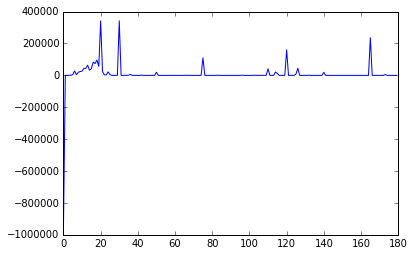

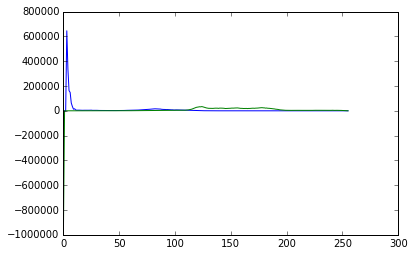

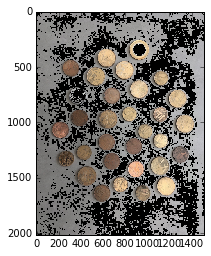

In [92]:
hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
h_ch, s_ch, v_ch = cv2.split(hsv_image)

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
#kernel = np.ones((15,15),np.uint8)
h_ch = cv2.morphologyEx(h_ch, cv2.MORPH_OPEN, kernel)
s_ch = cv2.morphologyEx(s_ch, cv2.MORPH_OPEN, kernel)
v_ch = cv2.morphologyEx(v_ch, cv2.MORPH_OPEN, kernel)


hist_h = cv2.calcHist([h_ch],[0],None,[180],[0,180])
hist_s = cv2.calcHist([s_ch],[0],None,[256],[0,256])
hist_v = cv2.calcHist([v_ch],[0],None,[256],[0,256])

hist_h = hist_h.ravel()
hist_s = hist_s.ravel()
hist_v = hist_v.ravel()

peak_h = np.argmax(hist_h)
peak_s = np.argmax(hist_s)
# peak_v = peakutils.indexes(hist_v, thres=0.2, min_dist=1)

delta = 3
for i in xrange(h_ch.shape[0]):
    for j in xrange(h_ch.shape[1]):
        if (h_ch[i][j] >= peak_h - delta) and (h_ch[i][j] < peak_h + delta):
            h_ch[i][j] = 0
            hist_s[s_ch[i][j]] -= 1
            s_ch[i][j] = 0
            hist_v[v_ch[i][j]] -= 1
            v_ch[i][j] = 0
for i in xrange(peak_h-delta, peak_h+delta):
    hist_h[i] = 0

# for i in xrange(s_ch.shape[0]):
#     for j in xrange(s_ch.shape[1]):
#         if (s_ch[i][j] >= peak_s - delta) and (s_ch[i][j] < peak_s + delta):
#             s_ch[i][j] = 0
#             hist_h[h_ch[i][j]] -= 1
#             h_ch[i][j] = 0
#             hist_v[v_ch[i][j]] -= 1
#             v_ch[i][j] = 0
# for i in xrange(peak_s-delta, peak_s+delta):
#     hist_s[i] = 0

    
# for i in xrange(s_ch.shape[0]):
#     for j in xrange(s_ch.shape[1]):
#         if s_ch[i][j] < 100:
#             h_ch[i][j] = 0
#             s_ch[i][j] = 0
#             v_ch[i][j] = 0

plt.plot(range(180), hist_h)
plt.show()
plt.plot(range(256), hist_s)
plt.plot(range(256), hist_v)
plt.show()


hsv_image = cv2.merge([h_ch, s_ch, v_ch])
rgb_image = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2RGB)
cv2.imwrite('filtered.jpeg', rgb_image)
plt.imshow(rgb_image)
plt.show()

0 1


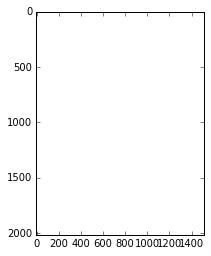

In [93]:
hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
h_ch, s_ch, v_ch = cv2.split(hsv_image)
h_ch = cv2.GaussianBlur(h_ch,(5,5),0)
s_ch = cv2.GaussianBlur(s_ch,(5,5),0)
v_ch = cv2.GaussianBlur(v_ch,(5,5),0)

# find normalized_histogram, and its cumulative distribution function
maxlevel = 256
# find normalized_histogram, and its cumulative distribution function
hist = cv2.calcHist([gray_image],[0],None,[maxlevel],[0,maxlevel])
hist_norm = hist.ravel()/hist.max()
Q = hist.cumsum()/Q[-1]
bins = np.arange(maxlevel)
fn_min = np.inf
th_1 = -1
th_2 = -1
for i in xrange(0, maxlevel-1):
    for j in xrange(i, maxlevel):
        p1,p2,p3 = np.hsplit(hist_norm,[i,j]) # probabilities
        q1,q2,q3 = Q[i], Q[j]-Q[i], Q[-1]-Q[j] # cum sum of classes
        b1,b2,b3 = np.hsplit(bins,[i,j]) # weights
        # finding means and variances
        m1 = np.sum(p1*b1)/q1 if q1 > 0.0 else 0.0
        m2 = np.sum(p2*b2)/q2 if q2 > 0.0 else 0.0
        m3 = np.sum(p3*b3)/q3 if q3> 0.0 else 0.0
        v1 = np.sum(((b1-m1)**2)*p1)/q1 if q1 > 0.0 else np.inf
        v2 = np.sum(((b2-m2)**2)*p2)/q2 if q2 > 0.0 else np.inf
        v3 = np.sum(((b3-m3)**2)*p3)/q3 if q3 > 0.0 else np.inf
        if q1 <= 0.0: q1 = np.inf
        if q2 <= 0.0: q2 = np.inf
        if q1 <= 0.0: q1 = np.inf
        # calculates the minimization function
        fn = v1*q1 + v2*q2 + v3*q3
        if fn < fn_min:
            fn_min = fn
            th_1 = i
            th_2 = j
print th_1, th_2
ot = otsu.OtsuFastMultithreshold()
ot.load_image(gray_image)
multi_otsu_img = ot.apply_thresholds_to_image([th_1, th_2])
plot_gray(multi_otsu_img)
#hsv_image = cv2.merge([multi_otsu_img, s_ch, v_ch])
#rgb_image = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2RGB)
# kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
# rgb_image = cv2.morphologyEx(rgb_image, cv2.MORPH_OPEN, kernel)
# rgb_image = cv2.dilate(rgb_image,kernel,iterations=1)
# rgb_image = cv2.morphologyEx(rgb_image, cv2.MORPH_CLOSE, kernel)
# rgb_image = cv2.morphologyEx(rgb_image, cv2.MORPH_OPEN, kernel)
# rgb_image = cv2.dilate(rgb_image,kernel,iterations=1)
# rgb_image = cv2.morphologyEx(rgb_image, cv2.MORPH_CLOSE, kernel)
#plt.imshow(rgb_image)
#plt.show()

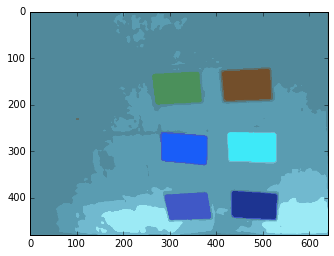

In [8]:
blur = cv2.GaussianBlur(image,(15,15),0)
Z = blur.reshape((-1,3))

# convert to np.float32
Z = np.float32(Z)

# define criteria, number of clusters(K) and apply kmeans()
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 11
ret,label,center=cv2.kmeans(Z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)

# Now convert back into uint8, and make original image
center = np.uint8(center)
res = center[label.flatten()]
res2 = res.reshape((image.shape))
plot_gray(res2)